#**Drive mount**

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


#**Imports**

In [ ]:
import torchvision.transforms.functional as TF
import sklearn.metrics
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
from torchvision.models.resnet import resnet50
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torchvision.io import read_image
from google.colab.patches import cv2_imshow
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchsummary import summary
import torchvision
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import cv2
from torchvision import datasets

#**Paths**

In [ ]:
sub_path = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub5'
train_path = sub_path + '/train'
test_path = sub_path + '/test'
val_path = sub_path + '/val'

#**Preparo il trasformatore**

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
val_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

#**Carico il dataset in train, path e val trasformandolo direttamente con il trasformatore**

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform = test_transforms)
val_dataset = torchvision.datasets.ImageFolder(root = val_path, transform = val_transforms)

#**Suddivido in dataloader per velocizzare l'allenamento**

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 4, shuffle=True)

#**Calcolo della mean e std per la normalizzazione valido sia per Grayscale che RGB, basta modificare il trasformatore**

In [ ]:
def mean_and_std(loader):

  channels_sum, channels_squared_sum, num_batches = 0, 0, 0

  for images, _ in loader:
    channels_sum += torch.mean(images, dim=[0,2,3])
    channels_squared_sum += torch.mean(images**2, dim=[0,2,3])
    num_batches += 1

  mean = channels_sum/num_batches
  std = (channels_squared_sum/num_batches - mean**2)**0.5

  return mean, std

#**Trasformatori completi anche di normalizzazione**

In [ ]:
mean, std = mean_and_std(train_loader)

train_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      #transforms.CenterCrop((224,192)),
      #transforms.RandomHorizontalFlip(),
      #transforms.RandomRotation(5),
      #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.67, fill=0), #probability=0.67 per le indicazioni del medico
      transforms.ToTensor(),
      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
      
])

val_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
      
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform = test_transforms)
val_dataset = torchvision.datasets.ImageFolder(root = val_path, transform = val_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 4, shuffle=True)

In [ ]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)), aspect='auto', cmap= 'jet')
    print("Labels:", labels)

show_transformed_images(train_dataset)

Text(0, 0.5, 'scale')

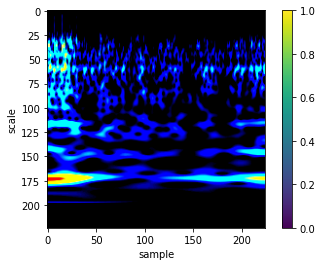

In [ ]:
loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle=True)
batch = next(iter(loader))
images, labels = batch
images = torch.squeeze(images, dim=0)
plt.imshow(np.transpose(images, (1,2,0)))
plt.colorbar()
plt.xlabel('sample')
plt.ylabel('scale')

In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

In [ ]:
plot_train_acc = []
plot_val_acc = []
plot_train_loss = []
lrs = []

def train_nn(model, train_loader, val_loader, optimizer, criterion, n_epochs):
  device = set_device()
  best_acc = 0
  for epoch in range(n_epochs):
    print("Epoch number %d" %(epoch + 1))
    model.train()
    curr_loss = 0.0
    curr_true = 0.0
    total = 0
    for data in train_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0) #perche anche se il batch è da 32 l'ultimo potrebbe essere più piccolo
      optimizer.zero_grad()

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1) #l'1 specifica il one dimension reduce

      loss = criterion(outputs, labels)

      loss.backward()
      
      optimizer.step()

      curr_loss += loss.item()
      curr_true += (labels==predicted).sum().item()

    epoch_loss = curr_loss/len(train_loader)
    epoch_accuracy = (curr_true/total)*100
    plot_train_acc.append(epoch_accuracy)
    plot_train_loss.append(epoch_loss)
    #scheduler.step()

    print("   -- Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch Loss: %.3f" %(curr_true, total, epoch_accuracy, epoch_loss))

    val_acc = evaluate_model_val(model, val_loader)
    plot_val_acc.append(val_acc)


    if(val_acc >= best_acc):
      best_acc = val_acc
      save_checkpoint(model, epoch, optimizer, best_acc)
      save_best_model(model)

  print("\n  -- Done!")
  return model

In [ ]:
def save_checkpoint(model, epoch, optimizer, best_acc):
  state = {
      'epoch': epoch + 1,
      'model': model.state_dict(),
      'best accuracy': best_acc,
      'optimizer': optimizer.state_dict(),
      'comments': ' -- SUB 28 CON 10 -- '
  }
  torch.save(state, 'checkpoint.pth.tar')

In [ ]:
def save_best_model(model):
  torch.save(model, '/content/drive/MyDrive/Tirocinio/BestModels/BestModels_Wavelet/best_model.pth.tar')

In [ ]:
def evaluate_model_val(model, val_loader):
  model.eval()
  true_predicted_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad(): #reduce memory usage and speed up the evaluation (no backpropagation che non si fa sul test)
    for data in val_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)

      true_predicted_on_epoch += (predicted==labels).sum().item()

    epoch_accuracy = (true_predicted_on_epoch/total)*100

    print("   -- Val Dataset. Got %d out of %d images correctly (%.3f%%)" %(true_predicted_on_epoch, total, epoch_accuracy))

  return epoch_accuracy


In [ ]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
num_classes = 2
model.fc = nn.Linear(num_features, num_classes)
device = set_device()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-5, dampening=0.1)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
class OurNet(nn.Module):

    def __init__(self, model, drop1, drop2):
        super().__init__()

        # ResNet50
        self.network = model
        
        # Replace last layer
        self.network._fc = nn.Sequential(nn.Conv2d(2048,512,(3, 3)),
                                         nn.Linear(512, 128), 
                                         nn.SELU(),
                                         nn.Dropout(drop1),
                                         nn.BatchNorm2d(128),
                                         nn.Linear(128, 32), 
                                         nn.SELU(),  
                                         nn.Dropout(drop2),
                                         nn.BatchNorm2d(32),
                                         nn.Linear(32,num_classes))
    
    def forward(self, x):
        out = self.network(x)
        return out

model = OurNet(model, 0.6, 0.5)

In [ ]:
train_nn(model, train_loader, val_loader, optimizer, loss_fn, 200)

In [ ]:
checkpoint = torch.load('checkpoint.pth.tar')

In [ ]:
print(checkpoint['epoch'])
print(checkpoint['best accuracy'])
print(checkpoint['comments'])

171
86.36363636363636
 -- SUB 5O CON 10 -- 


In [ ]:
best_model = torch.load('best_model.pth.tar')

In [ ]:
def showBadPredictedImages(predicteds, labels, imgs):
  for i in range(len(labels)):
    if predicteds[i] != labels[i]: #se la label predictada è diversa da quella effettiva
      print("label: ", labels[i], "predicted: ", predicteds[i])
      img = imgs[i].permute(1, 2, 0) 
      plt.figure()
      plt.imshow(img.numpy())
      plt.show()
      print("\n")

In [ ]:
all_pred = []
all_true = []
all_imgs = []

def evaluate_model_test(best_model, test_loader):

  best_model.eval()
  true_predicted_on_epoch = 0
  total = 0
  device = set_device()
  all_imgs = []
  #all_true = []
  
  with torch.no_grad(): #reduce memory usage and speed up the evaluation
    for data in test_loader:
      images, labels = data

      for img in images:
        all_imgs.append(img) 
      for lab in labels:
        all_true.append(float(lab))

      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)
     
      outputs = best_model(images)

      _, predicted = torch.max(outputs.data, 1)
      for pred in predicted:
        all_pred.append(float(pred))


      true_predicted_on_epoch += (predicted==labels).sum().item()
    
    epoch_accuracy = (true_predicted_on_epoch/total)*100
  print("   -- Test Dataset. Got %d out of %d images correctly (%.3f%%)" %(true_predicted_on_epoch, total, epoch_accuracy))
  precisionEval = metrics.precision_score(all_true, all_pred, zero_division=1)
  recallEval =  metrics.recall_score(all_true, all_pred, zero_division=1)
  f1Score = metrics.f1_score(all_true, all_pred, zero_division=1)
  print("   -- Test Dataset, recall: ", recallEval)
  print("   -- Test Dataset, precision: ", precisionEval)
  print("   -- Test Dataset, f1 score: ", f1Score)

  return epoch_accuracy

In [ ]:
test_acc = evaluate_model_test(best_model, test_loader)

##**Plots**

##**Confusion Matrix**

In [ ]:
def plotConfMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["normal", "abnormal"]
    plotConfMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()


In [ ]:
plt.plot(plot_train_acc, label = "Train Accuracy")
plt.plot(plot_val_acc, label = "Val Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(plot_train_loss, label = "Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(lrs, label = "Learning Rate")
plt.xlabel('time steps')
plt.ylabel('Lr')
plt.legend()
plt.show()
print(all_true)
print(all_pred)

plotConfusions(all_true, all_pred)

print("Confusion matrixes plotted.")

#Wandb

In [ ]:
!pip install wandb
import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 37.7 MB/s 
     |████████████████████████████████| 162 kB 69.9 MB/s 
     |████████████████████████████████| 182 kB 70.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 162 kB 69.7 MB/s 
     |████████████████████████████████| 158 kB 52.3 MB/s 
     |████████████████████████████████| 157 kB 52.6 MB/s 
     |████████████████████████████████| 157 kB 72.9 MB/s 
     |████████████████████████████████| 157 kB 67.2 MB/s 
     |████████████████████████████████| 157 kB 76.9 MB/s 
     |████████████████████████████████| 157 kB 69.7 MB/s 
     |████████████████████████████████| 157 kB 76.6 MB/s 
     |████████████████████████████████| 157 kB 68.9 MB/s 
     |████████████████████████████████| 156 kB 72.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=5

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'val_acc',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    
    'optimizer': {
        'values': ['sgd','rmsprop']
        },

    'drop1': {
          'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        },

    'drop2': {
          'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        },

    'learning_rate': {
        'distribution': 'uniform',
        'min': 0.00001,
        'max': 0.01
    },
    
    'momentum': {
        'distribution': 'uniform',
        'min': 0.9,
        'max': 1.0
    }  
    }

sweep_config['parameters'] = parameters_dict

sweep_id = wandb.sweep(sweep_config, project = "TL_ResNet_Wavelet")

Create sweep with ID: 5gfiqykt
Sweep URL: https://wandb.ai/valelore/TL_ResNet_Wavelet/sweeps/5gfiqykt


In [ ]:
from sklearn.metrics import accuracy_score
all_pred = []
all_true = []
all_imgs = []

def short_test(best_model):

  best_model.eval()
  true_predicted_on_epoch = 0
  total = 0
  device = set_device()
  all_imgs = []
  
  with torch.no_grad(): #reduce memory usage and speed up the evaluation (no backpropagation che non si fa sul test)
    for data in test_loader:
      images, labels = data

      for img in images:
        all_imgs.append(img) #mi salvo in una lista le immagini per ogni batch alla fine le avrò tutte
      for lab in labels:
        all_true.append(float(lab)) #mi salvo in una lista le labels per ogni batch alla fine le avrò tutte

      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)
     
      outputs = best_model(images)

      _, predicted = torch.max(outputs.data, 1)
      for pred in predicted:
        all_pred.append(float(pred)) #mi salvo tutte le prediction


      true_predicted_on_epoch += (predicted==labels).sum().item()
    
    epoch_accuracy = (true_predicted_on_epoch/total)*100
  print("   -- Test Dataset. Got %d out of %d images correctly (%.3f%%)" %(true_predicted_on_epoch, total, epoch_accuracy))
  precisionEval = metrics.precision_score(all_true, all_pred, zero_division=1)
  recallEval =  metrics.recall_score(all_true, all_pred, zero_division=1)
  f1Score = metrics.f1_score(all_true, all_pred, zero_division=1)
  print("   -- Test Dataset, recall: ", recallEval)
  print("   -- Test Dataset, precision: ", precisionEval)
  print("   -- Test Dataset, f1 score: ", f1Score)
  return epoch_accuracy

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

loss_fn = torch.nn.BCELoss()
sweep_code = 0
accuracies = {}

def build_network(drop1, drop2):
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    num_classes = 2
    model.fc = nn.Linear(num_features, num_classes)
    device = set_device()
    model = model.to(device)
    network = OurNet(model, drop1, drop2)

    return network

def build_optimizer(network, optimizer, learning_rate, mom):
    if optimizer == "rmsprop":
        optimizer = optim.RMSprop(network.parameters(),
                              lr=learning_rate)
    elif optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                               lr=learning_rate, momentum = mom)
    return optimizer

def train_epoch(model, train_loader, val_loader, optimizer, best_loss = 10000):
  model.train()
  curr_loss = 0.0
  curr_true = 0.0
  total = 0
  for data in train_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    total += labels.size(0) #perche anche se il batch è da 32 l'ultimo potrebbe essere più piccolo
    optimizer.zero_grad()

    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1) #l'1 specifica il one dimension reduce

    criterion = nn.CrossEntropyLoss()

    loss = criterion(outputs, labels)

    loss.backward()
    
    optimizer.step()

    curr_loss += loss.item()
    curr_true += (labels==predicted).sum().item()

  return curr_loss, curr_true, total

def train(config=None):

    with wandb.init(config=config):

        config = wandb.config

        best_acc = 0
        network = build_network(config.drop1, config.drop2)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate, config.momentum)
        best_loss = 10000
        n_epochs = 200
        for epoch in range(n_epochs):
          print("Epoch number %d" %(epoch + 1))
          curr_loss, curr_true, total = train_epoch(network, train_loader, val_loader, optimizer, best_loss)
          epoch_loss = curr_loss/len(train_loader)
          epoch_accuracy = (curr_true/total)*100

          print("   -- Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch Loss: %.3f" %(curr_true, total, epoch_accuracy, epoch_loss))

          val_acc = evaluate_model_val(network, val_loader)


          if(val_acc >= best_acc):
            best_acc = val_acc
            save_checkpoint(network, epoch, optimizer, best_acc)
            save_best_model(network)

          wandb.log({
              'Train acc': epoch_accuracy,
              'Train loss': epoch_loss,
              'Val acc': val_acc
            })

        print("\n  -- Done!")
        CURR_DIR = '/content/drive/MyDrive/Tirocinio/BestModels/BestModels_Wavelet'
        global sweep_code
        os.mkdir(CURR_DIR + "/" + str(sweep_code))
        os.replace(CURR_DIR + "/best_model.pth.tar", CURR_DIR + "/" + str(sweep_code) + "/best_model.pth.tar")
        
        network = torch.load(CURR_DIR + "/" + str(sweep_code) + "/best_model.pth.tar")
        acc = short_test(network)
        wandb.log({"test_accuracy": acc})
        sweep_code = sweep_code + 1


In [ ]:
wandb.agent(sweep_id, train, count = 10)

wandb: Agent Starting Run: 7wj5vmf4 with config:
wandb: 	drop1: 0
wandb: 	drop2: 0.1
wandb: 	learning_rate: 0.007863365817815658
wandb: 	momentum: 0.917998625007702
wandb: 	optimizer: sgd
wandb: Currently logged in as: valelore. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 1
   -- Training Dataset. Got 87 out of 158 images correctly (55.063%). Epoch Loss: 1.631
   -- Val Dataset. Got 13 out of 22 images correctly (59.091%)
Epoch number 2
   -- Training Dataset. Got 67 out of 158 images correctly (42.405%). Epoch Loss: 1.723
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoch number 3
   -- Training Dataset. Got 82 out of 158 images correctly (51.899%). Epoch Loss: 0.953
   -- Val Dataset. Got 8 out of 22 images correctly (36.364%)
Epoch number 4
   -- Training Dataset. Got 90 out of 158 images correctly (56.962%). Epoch Loss: 1.353
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoch number 5
   -- Training Dataset. Got 79 out of 158 images correctly (50.000%). Epoch Loss: 1.211
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoch number 6
   -- Training Dataset. Got 76 out of 158 images correctly (48.101%). Epoch Loss: 1.042
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoch

Train acc,▁▂▃▂▁▂▂▂▃▄▄▄▆▆▇▇█▇██████████████████████
Train loss,█▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val acc,▁▁▆▁▁▁▁▅▃█▆█▅▁▆▆▆▃▆▅▆▆▃▃▁▆█▅█▅▅▅▃▅▅▅▆██▁
test_accuracy,▁
Train acc,100.0
Train loss,9e-05
Val acc,50.0
test_accuracy,65.90909


wandb: Agent Starting Run: 2bz6s33n with config:
wandb: 	drop1: 0.3
wandb: 	drop2: 0.2
wandb: 	learning_rate: 0.003861620384614781
wandb: 	momentum: 0.9495211225977824
wandb: 	optimizer: sgd


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 1
   -- Training Dataset. Got 94 out of 158 images correctly (59.494%). Epoch Loss: 1.546
   -- Val Dataset. Got 12 out of 22 images correctly (54.545%)
Epoch number 2
   -- Training Dataset. Got 88 out of 158 images correctly (55.696%). Epoch Loss: 0.818
   -- Val Dataset. Got 17 out of 22 images correctly (77.273%)
Epoch number 3
   -- Training Dataset. Got 103 out of 158 images correctly (65.190%). Epoch Loss: 0.756
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoch number 4
   -- Training Dataset. Got 112 out of 158 images correctly (70.886%). Epoch Loss: 0.679
   -- Val Dataset. Got 16 out of 22 images correctly (72.727%)
Epoch number 5
   -- Training Dataset. Got 110 out of 158 images correctly (69.620%). Epoch Loss: 0.661
   -- Val Dataset. Got 13 out of 22 images correctly (59.091%)
Epoch number 6
   -- Training Dataset. Got 121 out of 158 images correctly (76.582%). Epoch Loss: 0.520
   -- Val Dataset. Got 17 out of 22 images correctly (77.273%)


Train acc,▁▄▅▆▇▇██████████████████████████████████
Train loss,█▅▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val acc,▁▁█▆▁█▁▃▃▃▃▃▃██▆▆▆▆▃█▆█▆██▆███▆███████▆█
test_accuracy,▁
Train acc,100.0
Train loss,7e-05
Val acc,90.90909
test_accuracy,77.27273


wandb: Agent Starting Run: 94s5jxf8 with config:
wandb: 	drop1: 0.6
wandb: 	drop2: 0.1
wandb: 	learning_rate: 0.006784611182909463
wandb: 	momentum: 0.900569178085108
wandb: 	optimizer: rmsprop


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 1
   -- Training Dataset. Got 78 out of 158 images correctly (49.367%). Epoch Loss: 2.313
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoch number 2
   -- Training Dataset. Got 77 out of 158 images correctly (48.734%). Epoch Loss: 0.745
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoch number 3
   -- Training Dataset. Got 84 out of 158 images correctly (53.165%). Epoch Loss: 0.716
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoch number 4
   -- Training Dataset. Got 69 out of 158 images correctly (43.671%). Epoch Loss: 0.714
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoch number 5
   -- Training Dataset. Got 89 out of 158 images correctly (56.329%). Epoch Loss: 0.694
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoch number 6
   -- Training Dataset. Got 75 out of 158 images correctly (47.468%). Epoch Loss: 0.705
   -- Val Dataset. Got 11 out of 22 images correctly (50.000%)
Epoc

wandb: Ctrl + C detected. Stopping sweep.
